In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import sys
import json
import importlib
from copy import deepcopy

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error as mse

from importlib import reload
from tqdm.notebook import tqdm
from numba import njit

sys.path.append('./ableen_module')
sys.path.append('./data')

from ableen_module import backtests as bt
from ableen_module import tools, gym, drawers

sns.set_theme(style='darkgrid')
sns.color_palette('rainbow')
plt.figure(figsize=(24, 12))

<Figure size 2400x1200 with 0 Axes>

<Figure size 2400x1200 with 0 Axes>

In [3]:
def get_mid_prices(coin):
    data = pd.read_csv('data/'+coin+'.csv')
    mid_prices = data['midpoint'][:17100]
    return mid_prices/np.mean(mid_prices)

In [4]:
session_lenght = 17100

# ПОДГРУЖАЕМ РЕАЛЬНЫЕ КУРСЫ
eth = get_mid_prices('ETH')
btc = get_mid_prices('BTC')
ada = get_mid_prices('ADA')

# ГЕНЕРИРУЕМ ЗАВИСИМЫЕ РЯДЫ
assets = ['hsecoin', 'pypycoin', 'weirdocoin', 'lolcoin', 'rucoin', 'easycoin']

hsecoin = btc*0.5+eth*0.2-ada*0.4
pypycoin = btc*0.3-eth*0.2+ada*0.5
weirdocoin = hsecoin*3-pypycoin-btc*0.5
lolcoin = pypycoin*1.4+btc*0.3-eth*0.1-ada*0.07+hsecoin-pypycoin*0.2
rucoin = lolcoin*0.5+pypycoin*0.6 + eth*0.1 + btc*0.15+weirdocoin*0.3
easycoin = lolcoin*3-rucoin+pypycoin/2

data_dict = dict()
data_dict['server_ts'] = np.arange(session_lenght)
data_dict['hsecoin'] = hsecoin
data_dict['rucoin'] = rucoin
data_dict['easycoin'] = easycoin
data_dict['lolcoin'] = lolcoin
data_dict['pypycoin'] = pypycoin
data_dict['weirdocoin'] = weirdocoin

data = pd.DataFrame(data_dict).set_index('server_ts')
data

,hsecoin,rucoin,easycoin,lolcoin,pypycoin,weirdocoin
server_ts,,,,,,
0,0.289052,1.048071,2.441568,1.072398,0.544889,-0.143719
1,0.288020,1.048649,2.446170,1.073761,0.547072,-0.149434
2,0.286877,1.049461,2.451462,1.075368,0.549639,-0.155974
3,0.288270,1.048023,2.443092,1.072696,0.546057,-0.147293
4,0.286349,1.047327,2.446451,1.073186,0.548440,-0.155410
...,...,...,...,...,...,...
17095,0.290977,1.078143,2.474951,1.089687,0.568067,-0.171508
17096,0.290855,1.078611,2.477640,1.090625,0.568751,-0.172871
17097,0.289512,1.077487,2.478172,1.090251,0.569813,-0.177641


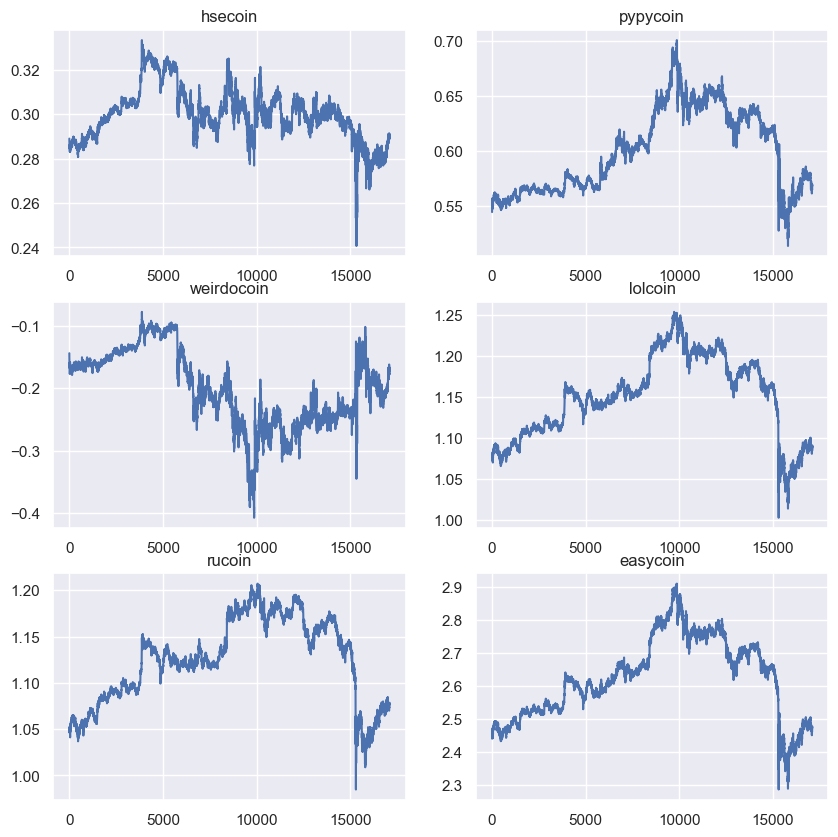

In [5]:
# ВИДИМ, ЧТО РЯДЫ ПРАВДА ИМЕЮТ ЗАВИСИМОСТИ

plt.figure(figsize=(10, 10))

for indx, inst in enumerate(assets):
    plt.subplot(3, 2, indx + 1)
    plt.plot(data[inst])
    plt.title(inst)
    
plt.show()

In [6]:
# ПРИМЕР ПРОСТЕЙШЕЙ РЕГРЕССИИ

TRAIN_SIZE = 1200

assets_data = np.array(data)
train, test = assets_data[:TRAIN_SIZE], assets_data[TRAIN_SIZE:]
X, y = assets_data[:, :-1], assets_data[:, -1]
X_train, y_train = X[:TRAIN_SIZE], y[:TRAIN_SIZE]
X_test, y_test = X[TRAIN_SIZE:], y[TRAIN_SIZE:]

In [7]:
weights, intercept = gym.my_ridge_train(train, 0.01)

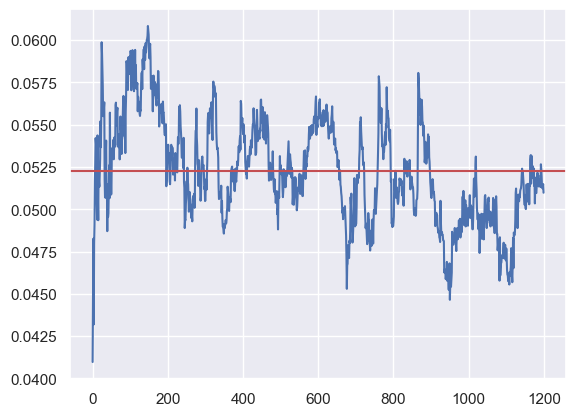

In [8]:
# TRAIN, по умолчанию целевой элемент последний
result_train = tools.linear_comb(assets_data[:TRAIN_SIZE], weights)
plt.plot(result_train)
plt.axhline(intercept, color='r')

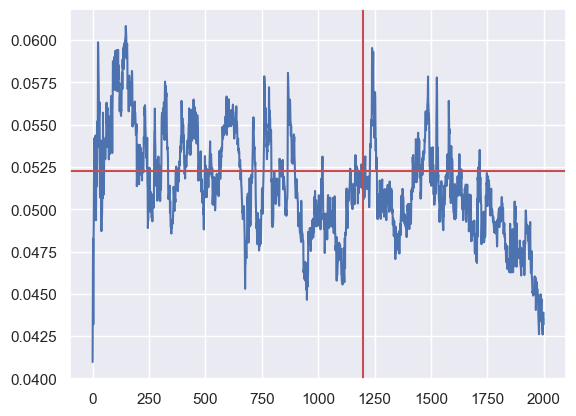

In [9]:
# TRAIN + TEST
result = tools.linear_comb(assets_data[:2000], weights)
plt.plot(result)
plt.axhline(intercept, color='r')
plt.axvline(TRAIN_SIZE, color='r')

In [10]:
# Случайные параметры
mv = drawers.ModelVisualizing(assets_data, assets_data)
mv.set_params(dependent_asset = -1, split_ts=12000, train_size=1200, test_size=500)

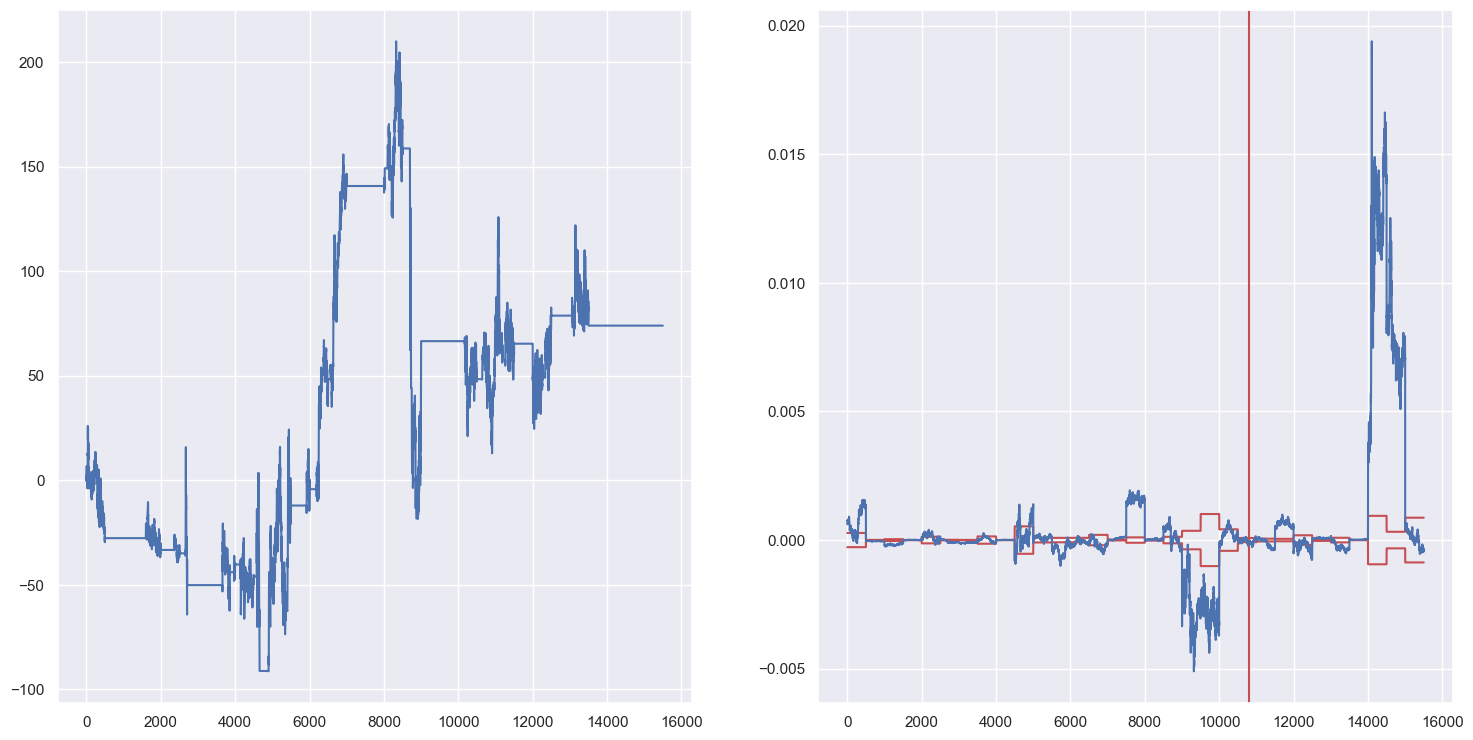

In [11]:
# Слева депозит, справа график изменений линейной комбинации и трешхолдов на всём периоде работы модели, вертикальная красная линия - разделение между TRAIN и TEST
wealthy, count = mv.show_the_case(log=False)